# Tracking Lorenz 63 using continuous-discrete Extended / Ensemble / Unscented Kalman filter

This notebook demonstrates tracking chaotic dynamics from the Lorenz 63 system from partial and noisy observations sampled at regular time intervals.

We generate dynamics according to the following stochastic differential equation:
\begin{align*}
\frac{d^2 x}{d t^2} &= a(y-x) + \sigma w_x(t) \\
\frac{d^2 y}{d t^2} &= x(b-z) - y + \sigma w_y(t) \\
\frac{d^2 z}{d t^2} &= xy - cz + \sigma w_z(t),
\end{align*}
where $a=10, b=28, c=8/3$ give rise to chaotic behavior, and we choose $\sigma=0.1$ for light diffusion.

We numerically approximate random path solutions to this SDE using Heun's method (i.e. improved Euler), as implemented in [Diffrax](https://docs.kidger.site/diffrax/api/solvers/sde_solvers/).


We assume the observation model is
\begin{align*}
y(t) &= x(t) + r(t) \\
r(t) &\sim N(0,R),
\end{align*}
where we choose $R=I$ and sample at a uniform interval $\Delta t \in \{0.01, 0.1\}$.

We approach the filtering problem using continuous-discrete Extended/Ensemble/Unscented Kalman Filters, and compare their performance. We see that the problem becomes more difficult when we have a slower sample rate and less knowledge of initial state distribution---in this setting, the Ensemble Kalman Filter shines and the Unscented Kalman Filter breaks at its first step (due to predicting a non-PSD state covariance).



Note that under regular sampling intervals, the typical discrete-time non-linear filtering paradigm is often sufficient. We do not compare to these for brevity. Instead, we simply demonstrate the performance of continuous-discrete methods.

## Setup

In [1]:
import sys
%matplotlib inline
sys.path.append("../../..")
sys.path.append("../..")

import dynamax
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as jr
from jax import vmap
from jax import lax
from jaxtyping import Float, Array
from typing import Callable, NamedTuple, Tuple, Optional, Union
from jaxtyping import Array, Float, PyTree

from dynamax.parameters import ParameterProperties

# For pretty print of ndarrays
jnp.set_printoptions(formatter={"float_kind": "{:.2f}".format})

# import discrete-time filters
from dynamax.nonlinear_gaussian_ssm import ParamsNLGSSM, UKFHyperParams
from dynamax.nonlinear_gaussian_ssm import extended_kalman_smoother, unscented_kalman_smoother

# import continuous-discrete nonlinear Gaussian SSM code
# use custom src codebase
from utils.plotting_utils import *
from continuous_discrete_nonlinear_gaussian_ssm import ContDiscreteNonlinearGaussianSSM
from continuous_discrete_nonlinear_gaussian_ssm import cdnlgssm_filter
from continuous_discrete_nonlinear_gaussian_ssm import EnKFHyperParams, EKFHyperParams, UKFHyperParams

# set up drift function
from continuous_discrete_nonlinear_gaussian_ssm.models import (
    LearnableFunction,
    ConstantLearnableFunction,
    LinearLearnableFunction,
)


/opt/homebrew/anaconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


In [2]:
def plot_lorenz(time_grid, x_tr, x_obs, x_est=None, est_type=""):
    plt.figure()
    n_states = x_tr.shape[1]
    for i in range(n_states):
        plt.plot(time_grid, x_tr[:, i], color=f"C{i}", alpha=0.5, linewidth=4, label=f"True State {i}")

    if x_est is not None:
        for i in range(n_states):
            plt.plot(
                time_grid, x_est[:, i], "--", color=f"C{i}", linewidth=1.5, label=f"{est_type} Estimated State {i}"
            )

    n_obs = x_obs.shape[1]
    for i in range(n_obs):
        plt.plot(time_grid, x_obs[:, i], "ok", fillstyle="none", ms=1.5, label=f"Measurement {i}")

    plt.xlabel("Time $t$")
    # plt.ylabel("Pendulum angle $x_{1,k}$")
    # plt.xlim(0, 5)
    # plt.ylim(-3, 5)
    # plt.xticks(jnp.arange(0.5, 4.6, 0.5))
    # plt.yticks(jnp.arange(-3, 5.1, 1))
    # plt.gca().set_aspect(0.5)
    plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor="k")
    plt.show()

In [3]:
# Compute RMSE
def compute_rmse(y, y_est):
    return jnp.sqrt(jnp.sum((y - y_est) ** 2) / len(y))


# Compute RMSE of estimate and print comparison with
# standard deviation of measurement noise
def compute_and_print_rmse_comparison(y, y_est, R, est_type=""):
    rmse_est = compute_rmse(y, y_est)
    print(f'{f"The RMSE of the {est_type} estimate is":<40}: {rmse_est:.2f}')
    print(f'{"The std of measurement noise is":<40}: {jnp.sqrt(R):.2f}')

In [4]:
## Main settings
state_dim = 3
emission_dim = 1


class CustomDrift(LearnableFunction):
    params: Union[Float[Array, "state_dim"], ParameterProperties]

    def f(self, x, u=None, t=None):
        foo = jnp.array(
            [
                self.params[0] * (x[1] - x[0]),
                self.params[1] * x[0] - x[1] - x[0] * x[2],
                -self.params[2] * x[2] + x[0] * x[1],
            ]
        )
        return foo


learnable_drift = CustomDrift(params=jnp.array([10.0, 28.0, 8 / 3]))
learnable_emission = LinearLearnableFunction(params=jnp.array([[1.0, 0.0, 0.0]]))
learnable_diffusion_cov = ConstantLearnableFunction(params=jnp.eye(state_dim))
learnable_diffusion_coefficient = ConstantLearnableFunction(params=0.1 * jnp.eye(state_dim))
learnable_emission_cov = ConstantLearnableFunction(params=jnp.eye(emission_dim))

true_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)

## Fast sample rate and modest initial state covariance

Sampling from transition distribution (this may be a poor approximation if you're simulating from a non-linear SDE). It is a highly appropriate choice for linear SDEs.
state.shape (3,)


Text(0.5, 1.0, 'Training Emissions')

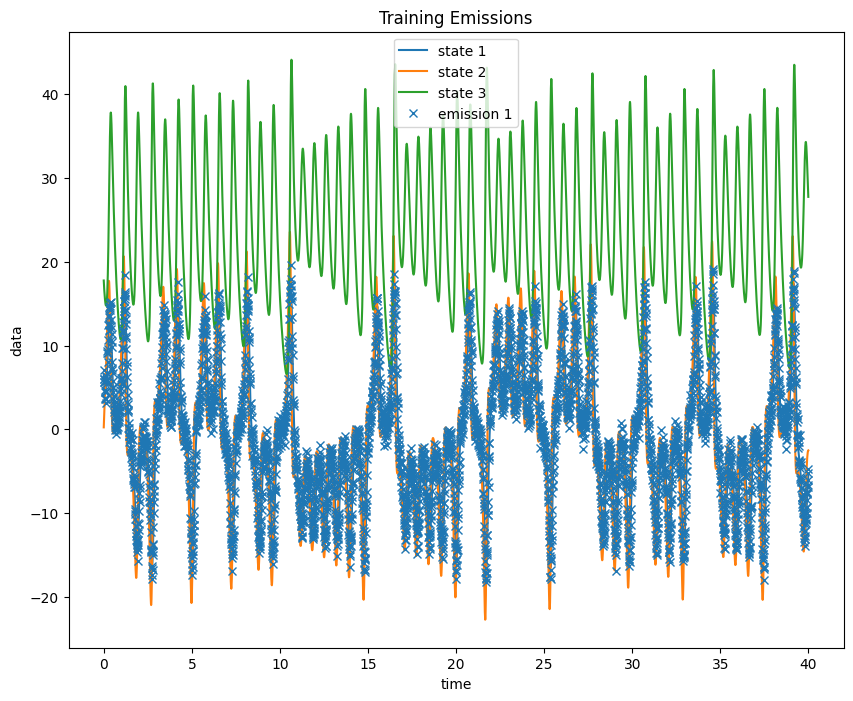

In [5]:
## Code

## HARD MODE
# num_timesteps = 250
# dt = 0.1
# init_state_sd = 20

## EASY MODE
num_timesteps = 4000
dt = 0.01
init_state_sd = 10

# set timesteps to be 400 timesteps at dt intervals
t_emissions = jnp.arange(num_timesteps) * dt
t_emissions = t_emissions.reshape(-1, 1)

key = jr.PRNGKey(0)
key, key_root = jr.split(key)
true_params, param_props = true_model.initialize(
    key,
    initial_mean=jnp.array([0.0, 0.0, 0.0]),
    initial_cov=jnp.eye(state_dim) * (init_state_sd**2),  # want to initialize at ~ initial mean
    dynamics_drift=learnable_drift,
    dynamics_diffusion_coefficient=learnable_diffusion_coefficient,
    dynamics_diffusion_cov=learnable_diffusion_cov,
    dynamics_approx_order=1.0,
    emission_function=learnable_emission,
    emission_cov=learnable_emission_cov,
)

key, key_root = jr.split(key)
true_states, emissions = true_model.sample(true_params, key, num_timesteps, t_emissions)

# Plot the true states and emissions
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t_emissions, true_states[:, 0], color="C0", label="state 1")
ax.plot(t_emissions, true_states[:, 1], color="C1", label="state 2")
ax.plot(t_emissions, true_states[:, 2], color="C2", label="state 3")
ax.plot(t_emissions, emissions[:, 0], "x", color="C0", label="emission 1")
ax.legend()
ax.set_ylabel("data")
ax.set_xlabel("time")
ax.set_title("Training Emissions")

### Extended Kalman Filter

The RMSE of the EKF estimate is         : 0.80
The std of measurement noise is         : 1.00


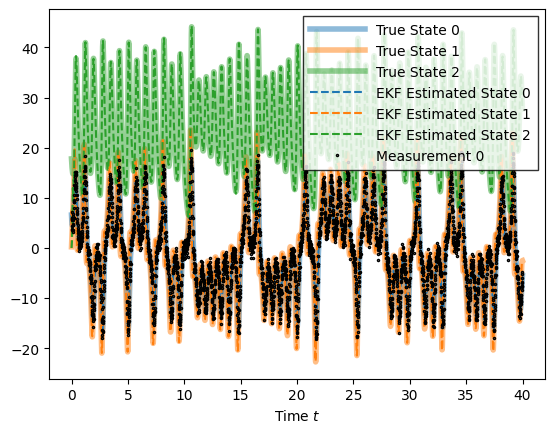

In [6]:
ekf_filtered = cdnlgssm_filter(true_params, emissions, EKFHyperParams(), t_emissions)
compute_and_print_rmse_comparison(true_states[:, -1], ekf_filtered.filtered_means[:,-1], 1, "EKF")
plot_lorenz(t_emissions, true_states, emissions, x_est=ekf_filtered.filtered_means, est_type="EKF")

### Ensemble Kalman Filter

The RMSE of the EKF estimate is         : 0.77
The std of measurement noise is         : 1.00


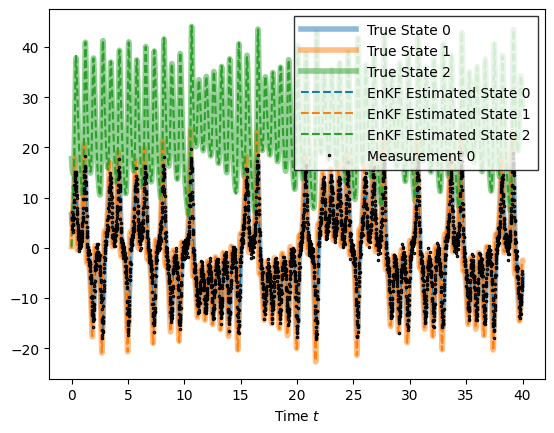

In [7]:
enkf_filtered = cdnlgssm_filter(true_params, emissions, EnKFHyperParams(), t_emissions)
compute_and_print_rmse_comparison(true_states[:, -1], enkf_filtered.filtered_means[:, -1], 1, "EKF")
plot_lorenz(t_emissions, true_states, emissions, x_est=enkf_filtered.filtered_means, est_type="EnKF")

### Unscented Kalman Filter


The RMSE of the UKF estimate is         : 0.78
The std of measurement noise is         : 1.00


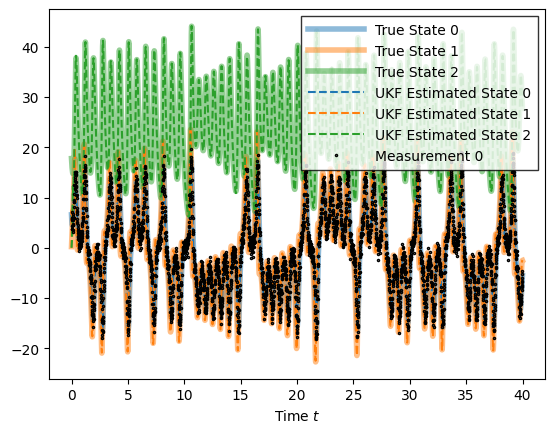

In [8]:
ukf_filtered = cdnlgssm_filter(true_params, emissions, UKFHyperParams(), t_emissions)
compute_and_print_rmse_comparison(true_states[:, -1], ukf_filtered.filtered_means[:, -1], 1, "UKF")
plot_lorenz(t_emissions, true_states, emissions, x_est=ukf_filtered.filtered_means, est_type="UKF")

## Slow sample rate and larger initial state covariance

Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.
state.shape (3,)


Text(0.5, 1.0, 'Training Emissions')

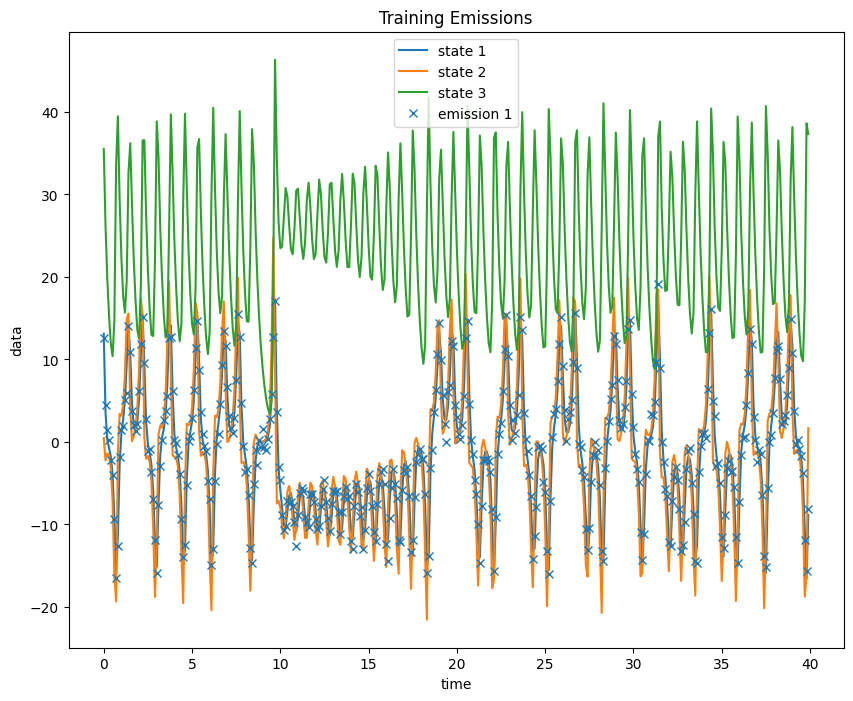

In [9]:
## Code

## HARD MODE
num_timesteps = 400
dt = 0.1
init_state_sd = 20

## EASY MODE
# num_timesteps = 4000
# dt = 0.01
# init_state_sd = 10

# set timesteps to be 400 timesteps at dt intervals
t_emissions = jnp.arange(num_timesteps) * dt
t_emissions = t_emissions.reshape(-1, 1)

key = jr.PRNGKey(0)
key, key_root = jr.split(key)
true_params, param_props = true_model.initialize(
    key,
    initial_mean=jnp.array([0.0, 0.0, 0.0]),
    initial_cov=jnp.eye(state_dim) * (init_state_sd**2),  # want to initialize at ~ initial mean
    dynamics_drift=learnable_drift,
    dynamics_diffusion_coefficient=learnable_diffusion_coefficient,
    dynamics_diffusion_cov=learnable_diffusion_cov,
    dynamics_approx_order=1.0,
    emission_function=learnable_emission,
    emission_cov=learnable_emission_cov,
)

key, key_root = jr.split(key)

# sample true states and emissions. Using transition_type="path" to solve SDE.
true_states, emissions = true_model.sample(true_params, key, num_timesteps, t_emissions, transition_type="path")

# Plot the true states and emissions
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t_emissions, true_states[:, 0], color="C0", label="state 1")
ax.plot(t_emissions, true_states[:, 1], color="C1", label="state 2")
ax.plot(t_emissions, true_states[:, 2], color="C2", label="state 3")
ax.plot(t_emissions, emissions[:, 0], "x", color="C0", label="emission 1")
ax.legend()
ax.set_ylabel("data")
ax.set_xlabel("time")
ax.set_title("Training Emissions")

### Extended Kalman Filter

The RMSE of the EKF estimate is         : 11.88
The std of measurement noise is         : 1.00


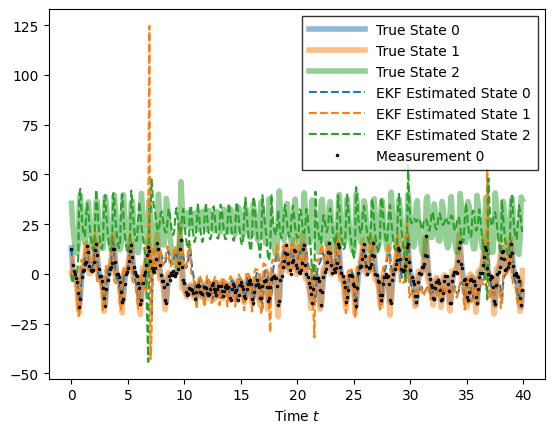

In [10]:
ekf_filtered = cdnlgssm_filter(true_params, emissions, EKFHyperParams(), t_emissions)
compute_and_print_rmse_comparison(true_states[:, -1], ekf_filtered.filtered_means[:, -1], 1, "EKF")
plot_lorenz(t_emissions, true_states, emissions, x_est=ekf_filtered.filtered_means, est_type="EKF")

### Ensemble Kalman Filter

The RMSE of the EnKF estimate is        : 2.20
The std of measurement noise is         : 1.00


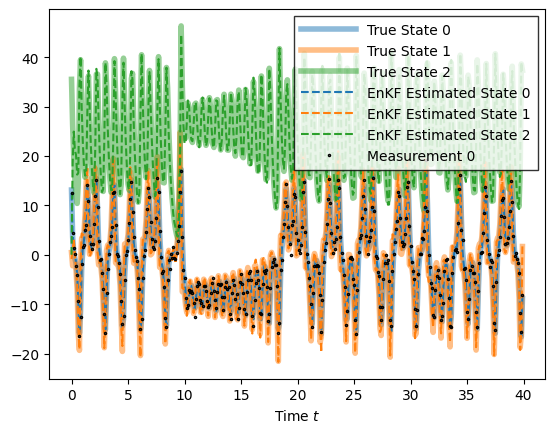

In [11]:
enkf_filtered = cdnlgssm_filter(true_params, emissions, EnKFHyperParams(), t_emissions)
compute_and_print_rmse_comparison(true_states[:, -1], enkf_filtered.filtered_means[:, -1], 1, "EnKF")
plot_lorenz(t_emissions, true_states, emissions, x_est=enkf_filtered.filtered_means, est_type="EnKF")

### Unscented Kalman Filter


The RMSE of the UKF estimate is         : nan
The std of measurement noise is         : 1.00


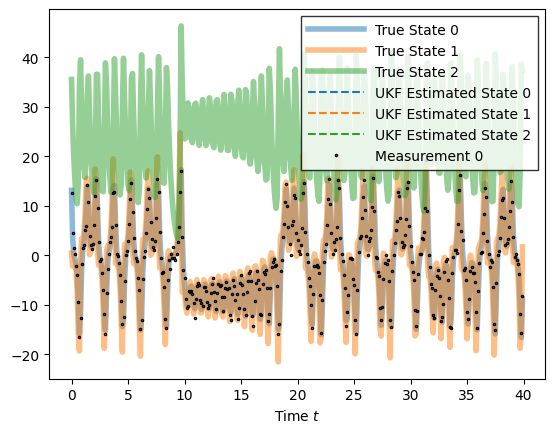

In [12]:
ukf_filtered = cdnlgssm_filter(true_params, emissions, UKFHyperParams(), t_emissions)
compute_and_print_rmse_comparison(true_states[:, -1], ukf_filtered.filtered_means[:, -1], 1, "UKF")
plot_lorenz(t_emissions, true_states, emissions, x_est=ukf_filtered.filtered_means, est_type="UKF")

Unclear why UKF is failing here---I've pinpointed the issue to the first call of _predict in the UKF. More specifically, the first step of an Euler approximation yields a dP/dt that is very non-psd. This comes from the deterministic term given by (f_x_t.T @ W @ X_t) + (f_x_t.T @ W @ X_t).T.